In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.integrate import solve_ivp
# numpy.linalg is also an option for even fewer dependencies

In [16]:
def dk(self, X):
    x1, y1, z1, x2, y2, z2 = X
    return [y1 + b*x1**2 - a*x1**3 -z1 + I - k1*(x1-vs)*G(x2),
            c - d*x1**2 - y1,
            r*(s*(x1 - xr) - z1),
            y2 + b*x2**2 - a*x2**3 -z2 + I - k2*(x2-vs)*G(x1),
            c - d*x2**2 - y2,
            r*(s*(x2 - xr) - z2)        
    ]
 
def G(x):
    return 1/(1+np.exp(-lam*(x-teta)))

a = 1
b = 3
c = 1
d = 5
xr = -1.6
r = 0.01
s = 5
I = 4
vs = 2
lam = 10
teta = -0.25
k1 = -0.17
k2 = -0.17



sol = solve_ivp(dk, [0, 50200], [-0.1, 0.1, -0.1, 0.1, -0.1, 0.1], 
                t_eval=np.array(range(200, 50200, 1)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [17]:
np.save("HRData", sol.y)

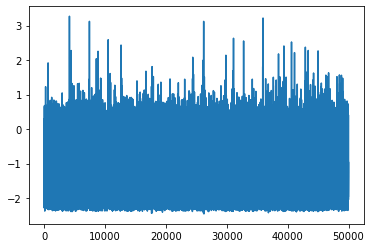

In [18]:
plt.plot(sol.y[0] + sol.y[3])

In [19]:
sol.y.dtype

dtype('float64')

Text(0.5, 1.0, 'A sample of data')

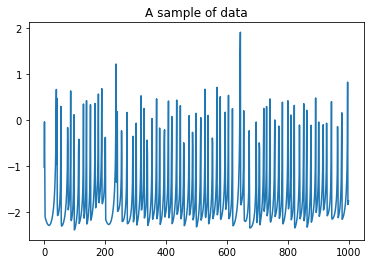

In [20]:
# load the data
trainLen = 45000
testLen = 4999
initLen = 0
y = np.load("HRData.npy")
data = y[0] + y[3]

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

In [23]:
def ReservoirComputings(data, a=0.5, size=400, spectral_radius=0.001):



    # generate the ESN reservoir
    inSize = outSize = 1
    resSize = size
#     a = 0.5 # leaking rate
    np.random.seed(42)
    Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
    W = (np.random.rand(resSize,resSize) - 0.5) * 2 
    for i in range(resSize):
        W[i][i] = 0
    # normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...')
    rhoW = max(abs(linalg.eig(W)[0]))
    print('done.')
    W *= spectral_radius / rhoW

    # allocated memory for the design (collected states) matrix
    X = np.zeros((1+inSize+resSize,trainLen-initLen))
    # set the corresponding target matrix directly
    Yt = data[None,initLen+1:trainLen+1] 

    # run the reservoir with the data and collect X
    x = np.zeros((resSize,1))
    for t in range(trainLen):
        u = data[t]
        x = (1-a)*x + a*np.tanh(np.dot(Win, np.vstack((1,u))) + np.dot( W, x ) )
        if t >= initLen:
            X[:,t-initLen] = np.vstack((1,u,x))[:,0]
    reservoir_end = x 
    # train the output by ridge regression
    reg = 1e-8  # regularization coefficient
    # direct equations from texts:
    #X_T = X.T
    #Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
    #    reg*np.eye(1+inSize+resSize) ) )
    # using scipy.linalg.solve:
    Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
        np.dot(X,Yt.T) ).T

    # run the trained ESN in a generative mode. no need to initialize here, 
    # because x is initialized with training data and we continue from there.
    Y = np.zeros((outSize,testLen))
    u = data[trainLen]
    for t in range(testLen):
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
        y = np.dot( Wout, np.vstack((1,u,x)) )
        Y[:,t] = y
        # generative mode:
        #u = y
        ## this would be a predictive mode:
        u = data[trainLen+t+1] 

    # compute MSE for the first errorLen time steps
    errorLen = 100
    mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
        Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return Y

    # # plot some signals
    # plt.figure(1).clear()
    # plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
    # plt.plot( Y.T, 'b' )
    # plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    # plt.legend(['Target signal', 'Free-running predicted signal'])

    # plt.figure(2).clear()
    # plt.plot( X[0:20,0:200].T )
    # plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

    # plt.figure(3).clear()
    # plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
    # plt.title(r'Output weights $\mathbf{W}^{out}$')

    # plt.show()

In [24]:
res1 = ReservoirComputings(data)

Computing spectral radius...
done.
MSE = 0.1254165182530376


Text(0.5, 1.0, 'A sample of data')

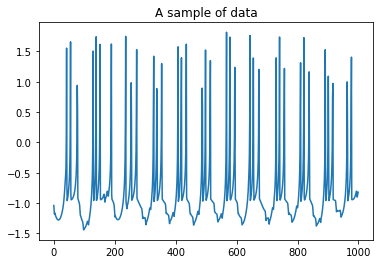

In [25]:
# load the data
trainLen = 45000
testLen = 4999
initLen = 0
y = np.load("HRData.npy")
data = y[0]

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

In [26]:
res2_1 = ReservoirComputings(data)

Computing spectral radius...
done.
MSE = 0.0019396567918302191


Text(0.5, 1.0, 'A sample of data')

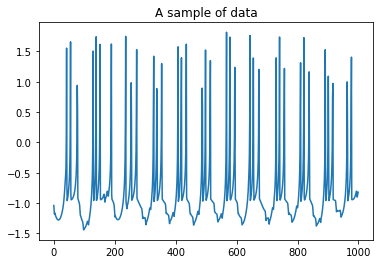

In [27]:
trainLen = 45000
testLen = 4999
initLen = 0
y = np.load("HRData.npy")
data = y[0]

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

In [28]:
res2_2 = ReservoirComputings(data)

Computing spectral radius...
done.
MSE = 0.0019396567918302191


In [29]:
res2 = res2_1 + res2_2

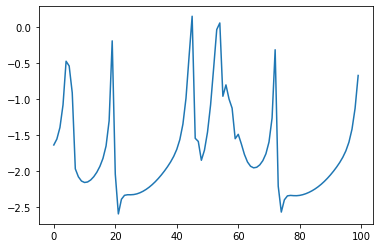

In [32]:
plt.plot(res1[0, :100])

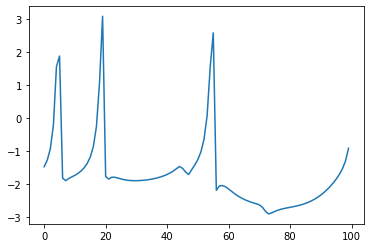

In [33]:
plt.plot(res2[0, :100])

In [34]:
trainLen = 45000
testLen = 4999
initLen = 0
y = np.load("HRData.npy")
data = y[0] + y[3]

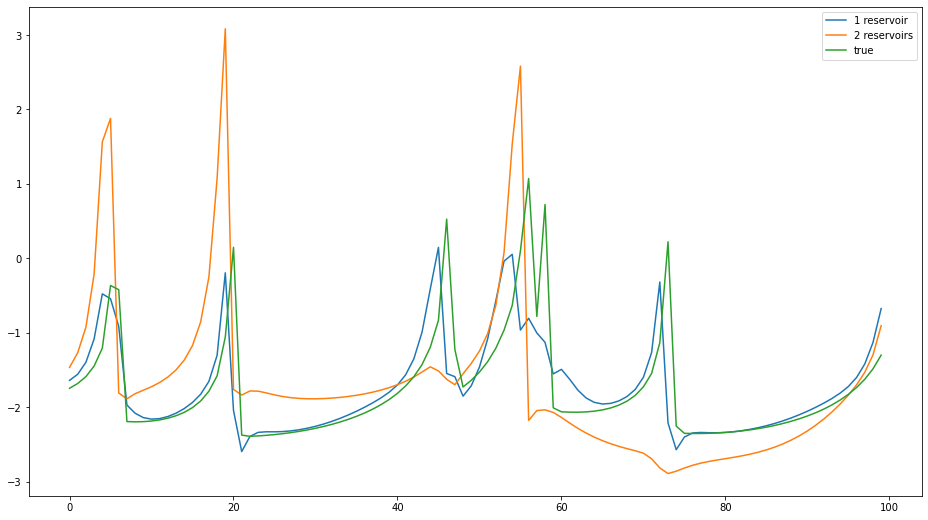

In [36]:
plt.figure(figsize=(16, 9))
plt.plot(res1[0, :100], label="1 reservoir")
plt.plot(res2[0, :100], label="2 reservoirs")
plt.plot(data[45000:45100], label="true")
plt.legend()

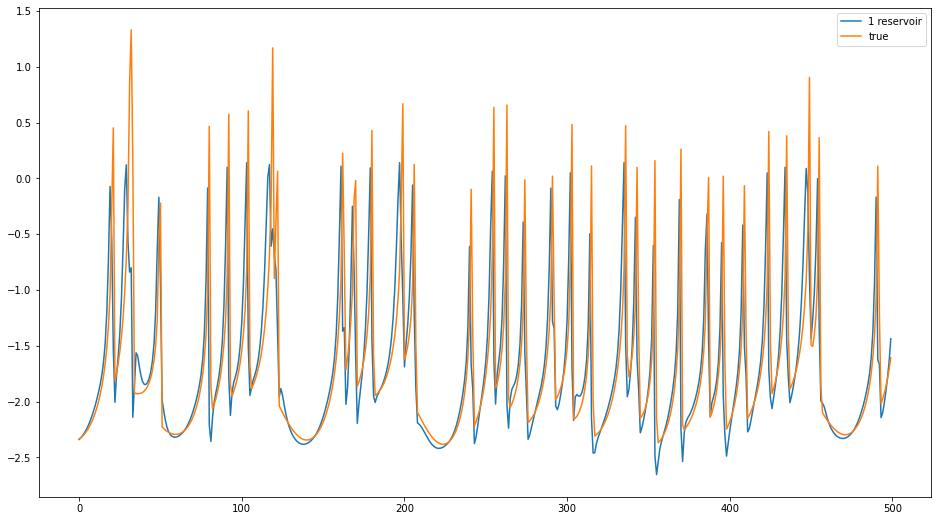

In [40]:
plt.figure(figsize=(16, 9))
plt.plot(res1[0, 500:1000], label="1 reservoir")
#plt.plot(res2[0, :1000], label="2 reservoirs")
plt.plot(data[45500:46000], label="true")
plt.legend()

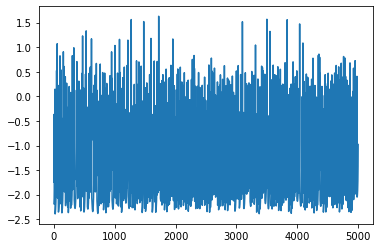

In [41]:
plt.plot(data[45000:])